## This Notebook is run in a Kaggle P100 notebook instance

We used ConvNeXT transformer as the classification model. We finetuned it on the Auto-WCE dataset
__________

### Installing the dependencies

In [1]:
!pip install -q transformers datasets

In [3]:
# All these are done so as to resolve certain dependency errors!
! pip install -q -U accelerate
! pip install -q -U transformers
!pip install -q datasets==2.9.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
pathos 0.3.1 requires dill>=0.3.7, but you have dill 0.3.6 which is incompatible.
pathos 0.3.1 requires multiprocess>=0.70.15, but you have multiprocess 0.70.14 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.


### Logging in to huggingface so as to push the dataset and model to the Hub

In [5]:
from huggingface_hub import notebook_login
notebook_login()

### Imports

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict, load_metric, load_dataset
import torch
from torch import nn
import transformers
from transformers import ConvNextFeatureExtractor, AutoModelForImageClassification, TrainingArguments, Trainer
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import EarlyStoppingCallback
import accelerate
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_fscore_support, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Handling

In [2]:
## Loading the dataset from Kaggle

dataset = load_dataset("imagefolder", data_dir="/kaggle/input/misahub-wce-dataset")

In [9]:
dataset  # sanity check

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2618
    })
})

In [10]:
np.array(dataset['train'][0]['image']).shape  # sanity check

(224, 224, 3)

In [11]:
# sanity checks

print(f"Number of examples in the entire dataset: {len(dataset['train'])}")
dataset = dataset['train'].train_test_split(test_size=0.2, shuffle=True, seed=42)
print(f"Number of examples in training set: {len(dataset['train'])}")
print(f"Number of examples in validation set: {len(dataset['test'])}")

Number of examples in the entire dataset: 2618
Number of examples in training set: 2094
Number of examples in validation set: 524


In [12]:
dataset  # sanity check

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2094
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 524
    })
})

In [13]:
dataset_dict = DatasetDict({
              "train": dataset['train'],
              "validation": dataset['test']})

print(dataset_dict)  # sanity check

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2094
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 524
    })
})


In [14]:
## Pushing the dataset to the HuggingFace Hub

dataset_dict.push_to_hub("MisaHub_WCE_train_val")

  0%|          | 0/3 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

## Loading the already pushed dataset from HuggingFace

In [15]:
## Loading the dataset from the HuggingFace Hub

dataset = load_dataset("Aaryan333/MisaHub_WCE_train_val")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2094 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/524 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Aaryan333___parquet/Aaryan333--MisaHub_WCE_train_val-fa674f4364947da8/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
dataset  # sanity check

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2094
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 524
    })
})

In [18]:
dataset["train"].features  # sanity check

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['bleeding', 'non_bleeding'], id=None)}

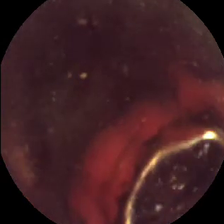

In [19]:
example = dataset["train"][0]  
example["image"]  # sanity check

In [20]:
example["label"]  # sanity check (corresponds to bleeding)

0

In [21]:
class_labels = dataset["train"].features["label"].names
print(class_labels)  # sanity check

['bleeding', 'non_bleeding']


In [22]:
id2label = {k:v for k,v in enumerate(class_labels)}
label2id = {v:k for k,v in enumerate(class_labels)}  # will be needed later

In [23]:
id2label  # sanity check

{0: 'bleeding', 1: 'non_bleeding'}

### ConvNeXT Preprocessing

In [24]:
feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")

In [25]:
print(feature_extractor)  # sanity check

ConvNextFeatureExtractor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [32]:
## Loading torchvision transforms

from torchvision.transforms import Compose, Resize, ToTensor

transform = Compose(
    [
     Resize(feature_extractor.size['shortest_edge']),  # ConvNeXT needs images of this size
     ToTensor()  # so PIL to Tensor
    ]
)

In [33]:
def transforms(examples):
    examples["pixel_values"] = [transform(img.convert("RGB")) for img in examples["image"]]
    return examples

In [34]:
processed_dataset = dataset.with_transform(transforms)  

# applies transforms on the fly when in use only, doesn't apply the transform beforehand and save in memory!

In [35]:
processed_dataset["train"][0]["pixel_values"].shape  # sanity check

torch.Size([3, 224, 224])

In [36]:
processed_dataset["train"][0]  # pixel_values will be loaded on fly

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 0,
 'pixel_values': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]])}

### Model Creation and Training

In [40]:
model = AutoModelForImageClassification.from_pretrained("facebook/convnext-tiny-224", num_labels=len(class_labels), id2label=id2label, label2id=label2id,
                                                                        ignore_mismatched_sizes=True)

# we use ignore_mismatched_sizes=True coz "facebook/convnext-tiny-224" is already a fine-tuned model which has a classification head. By giving this param, we tell the
#model to ignore this classification head and instead create a new one with 'lables' no. of classes in the classification head

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# defining the training args

args = TrainingArguments(
    output_dir="results",
    remove_unused_columns=False,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=5e-4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs'
)

# remove_unused_columns=False. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop
#unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular)
#in order to create 'pixel_values'.

In [42]:
# defining the metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [43]:
print(model) # sanity check

ConvNextForImageClassification(
  (convnext): ConvNextModel(
    (embeddings): ConvNextEmbeddings(
      (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (layernorm): ConvNextLayerNorm()
    )
    (encoder): ConvNextEncoder(
      (stages): ModuleList(
        (0): ConvNextStage(
          (downsampling_layer): Identity()
          (layers): Sequential(
            (0): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              (pwconv1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELUActivation()
              (pwconv2): Linear(in_features=384, out_features=96, bias=True)
              (drop_path): Identity()
            )
            (1): ConvNextLayer(
              (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (layernorm): ConvNextLayerNorm()
              

In [44]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [45]:
# preparing the trainer

trainer = Trainer(model=model, 
                  args=args, 
                  train_dataset=processed_dataset['train'], 
                  eval_dataset=processed_dataset['validation'], 
                  compute_metrics=compute_metrics,
                  data_collator=collate_fn,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
                 )

### Training

In [46]:
## start the training!

trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.020746,0.994275
2,No log,0.206492,0.944656
2,No log,0.000906,1.000000
4,No log,0.019899,0.996183
4,No log,0.018387,0.998092
6,No log,0.018079,0.998092


TrainOutput(global_step=393, training_loss=0.03230318404336012, metrics={'train_runtime': 309.6705, 'train_samples_per_second': 101.43, 'train_steps_per_second': 3.149, 'total_flos': 3.157036493336248e+17, 'train_loss': 0.03230318404336012, 'epoch': 6.0})

### Pushing the Model to the Hub

In [47]:
repo_name = "convnext-tiny-finetuned-misahub-auto-wce"

model.push_to_hub(repo_name)
feature_extractor.push_to_hub(repo_name)

pytorch_model.bin:   0%|          | 0.00/111M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Aaryan333/convnext-tiny-finetuned-misahub-auto-wce/commit/4eff1100c1bec53bae3743fbe41e82d0de5b5219', commit_message='Upload feature extractor', commit_description='', oid='4eff1100c1bec53bae3743fbe41e82d0de5b5219', pr_url=None, pr_revision=None, pr_num=None)

### Evaluation

In [48]:
val_outputs = trainer.predict(processed_dataset['validation'])

In [50]:
print(val_outputs.metrics)

{'test_loss': 0.0009060282027348876, 'test_accuracy': 1.0, 'test_runtime': 3.0883, 'test_samples_per_second': 169.671, 'test_steps_per_second': 21.371}


In [51]:
y_val = val_outputs.label_ids
val_predictions = val_outputs.predictions.argmax(axis=1)

In [52]:
target_classes=[]

for i in id2label.values():
    target_classes.append(i)

In [53]:
# validation data's metrics

print(confusion_matrix(y_val, val_predictions))
print('\n')
macroF1 = precision_recall_fscore_support(y_val, val_predictions, average='macro')
microF1 = precision_recall_fscore_support(y_val, val_predictions, average='micro')
print("Marco Precision Recall & F1 Scores: {}".format(macroF1))
print("Micro Precision Recall & F1 Scores: {}".format(microF1))
print("\n")
print(classification_report(y_val, val_predictions, target_names=target_classes))

[[255   0]
 [  0 269]]


Marco Precision Recall & F1 Scores: (1.0, 1.0, 1.0, None)
Micro Precision Recall & F1 Scores: (1.0, 1.0, 1.0, None)


              precision    recall  f1-score   support

    bleeding       1.00      1.00      1.00       255
non_bleeding       1.00      1.00      1.00       269

    accuracy                           1.00       524
   macro avg       1.00      1.00      1.00       524
weighted avg       1.00      1.00      1.00       524



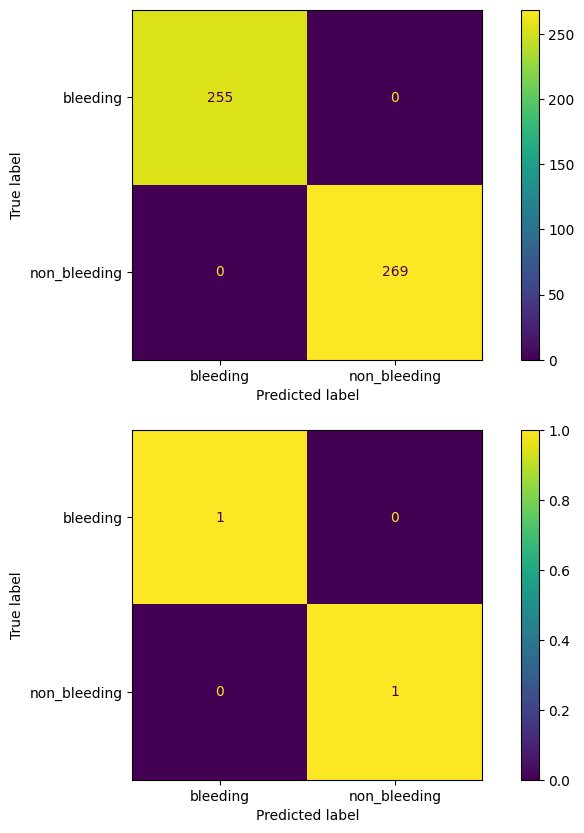

In [57]:
#plotting the confusion matrix for validation data:

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
cm_plot_1 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions), display_labels=target_classes)
cm_plot_2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val, val_predictions, normalize='pred'), display_labels=target_classes)
cm_plot_1.plot(ax=ax1)
cm_plot_2.plot(ax=ax2)

plt.show()

__________________